In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import metrics 
import warnings
warnings.filterwarnings('ignore')
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
# evaluation 
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
#Loading the dataset
diabetes_data = pd.read_csv('/content/diabetes.csv')

#Print the first 5 rows of the dataframe.
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [14]:
## observing the shape of the data
diabetes_data.shape

(768, 9)

In [15]:
#renaming column names for better understanding 
diabetes_data.columns = ["pregnancies", "glucose", "blood_pressure", "skin_thickness","insulin","bmi","Diabetes_Pedigree_Function","age","outcome"]
diabetes_data.head()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,Diabetes_Pedigree_Function,age,outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [16]:
X = diabetes_data.drop("outcome",axis = 1)
y = diabetes_data.outcome

In [17]:
X.head()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,Diabetes_Pedigree_Function,age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [18]:
#importing train_test_split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=1/3,random_state=42, stratify=y)

In [19]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

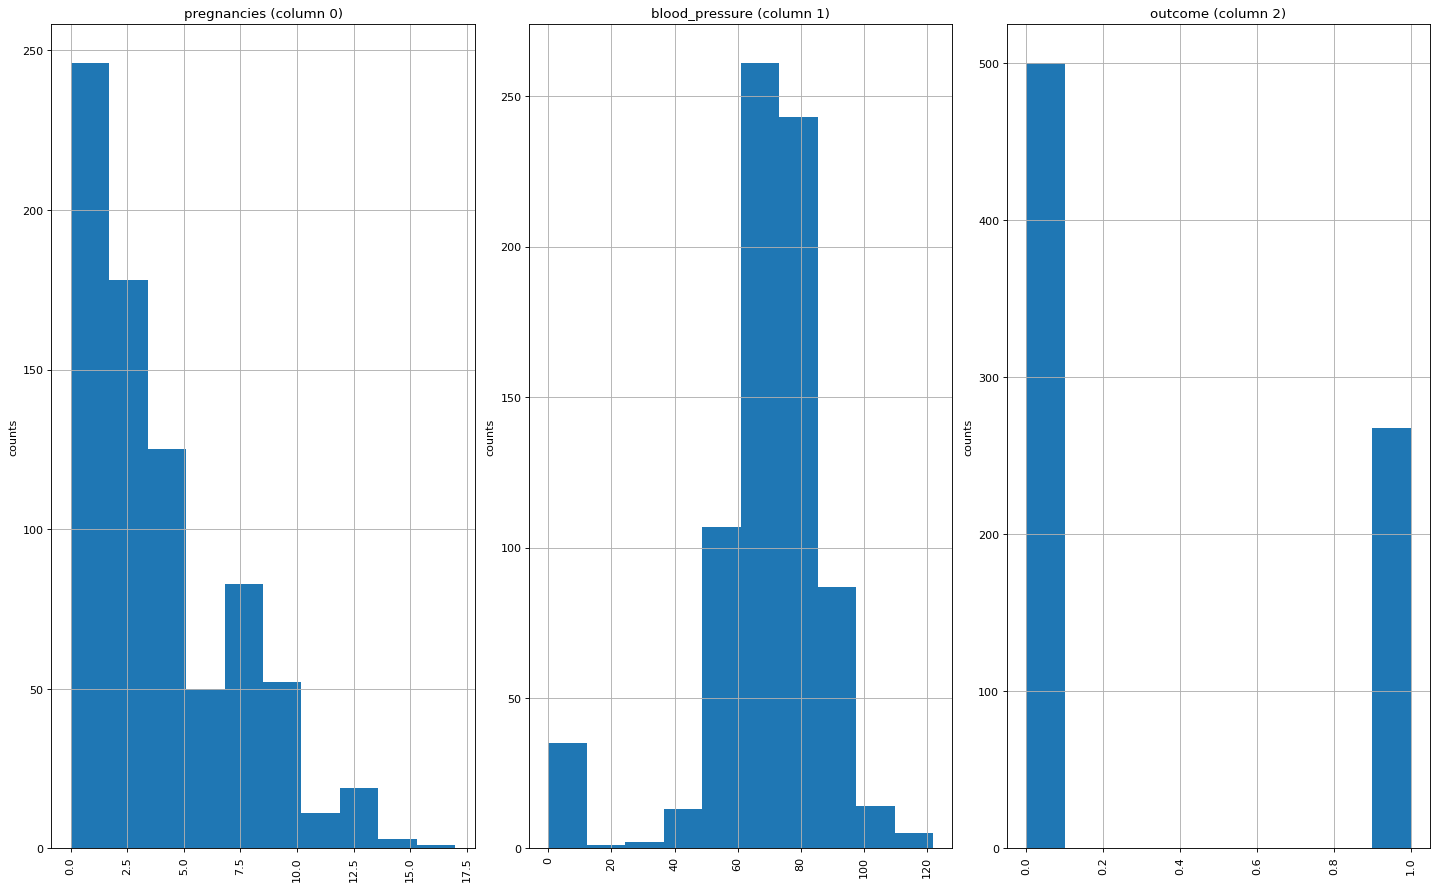

In [20]:
plotPerColumnDistribution(diabetes_data, 10, 5)

In [21]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

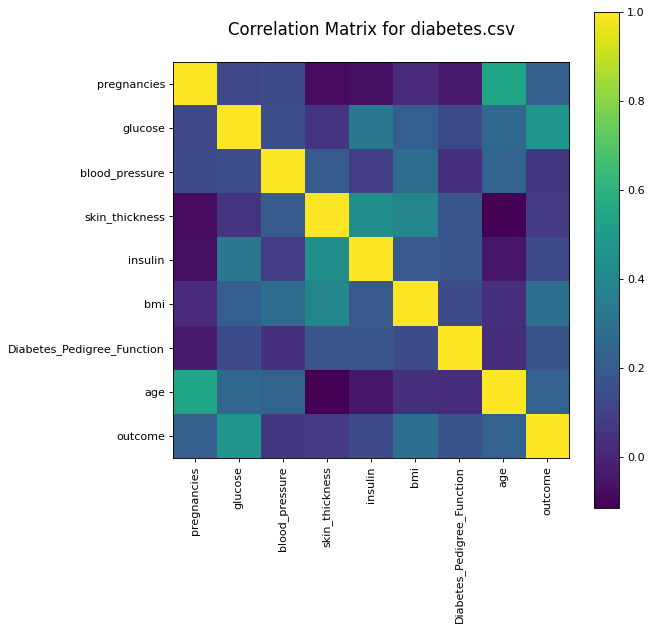

In [22]:
diabetes_data.dataframeName = 'diabetes.csv'
plotCorrelationMatrix(diabetes_data, 8)

In [23]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

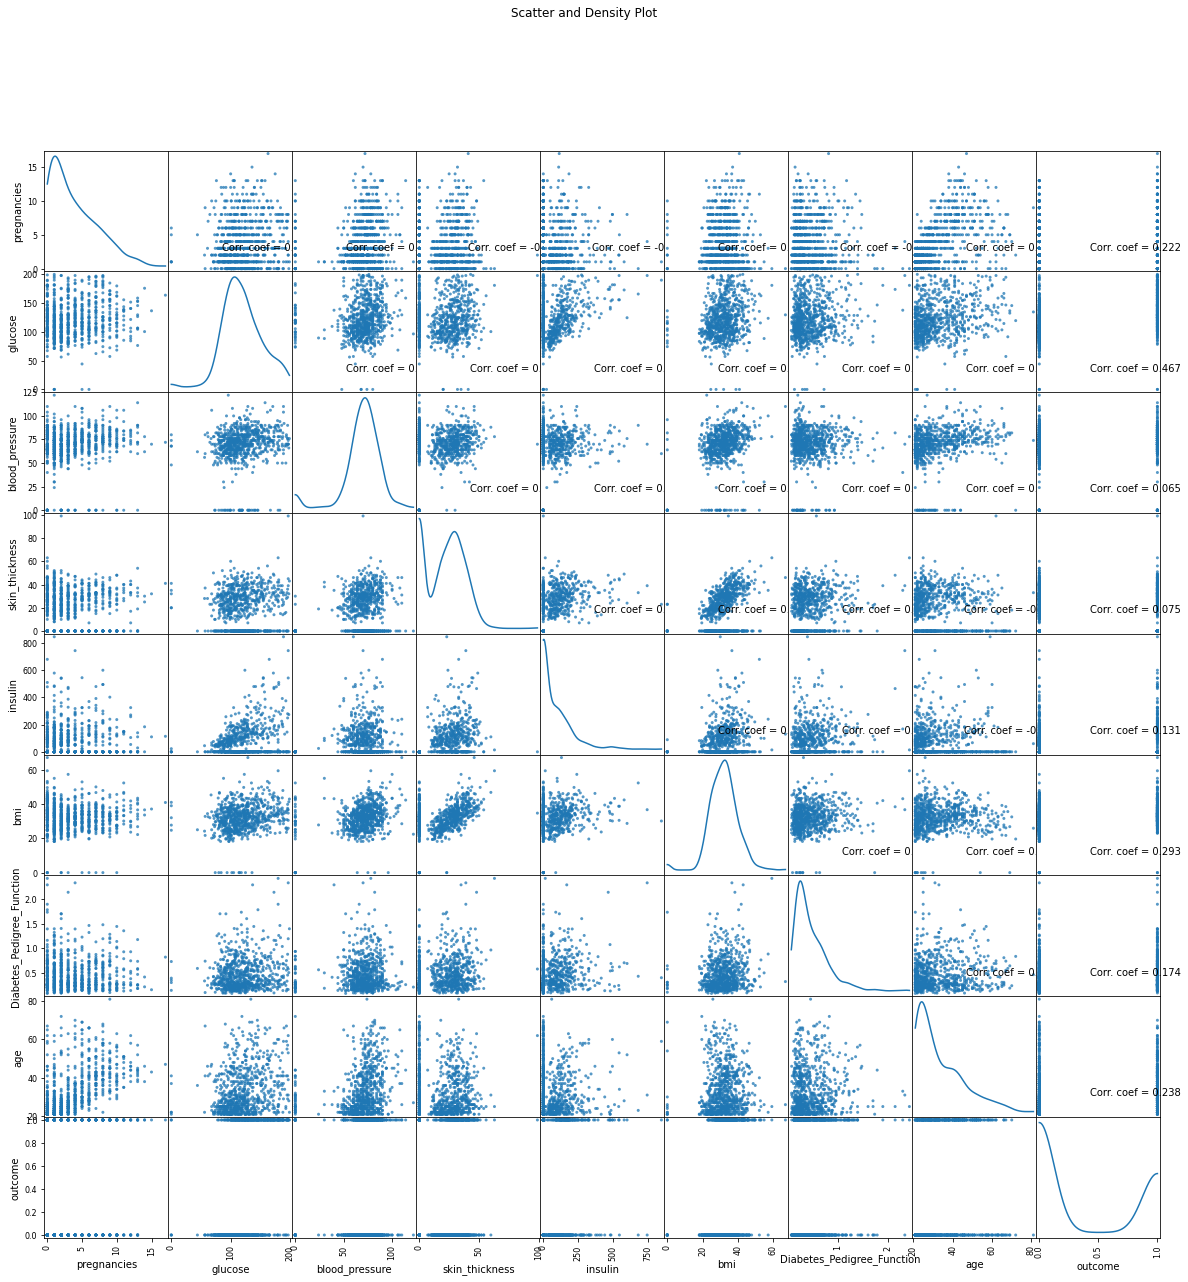

In [24]:
plotScatterMatrix(diabetes_data, 20, 10)

In [25]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   pregnancies                 768 non-null    int64  
 1   glucose                     768 non-null    int64  
 2   blood_pressure              768 non-null    int64  
 3   skin_thickness              768 non-null    int64  
 4   insulin                     768 non-null    int64  
 5   bmi                         768 non-null    float64
 6   Diabetes_Pedigree_Function  768 non-null    float64
 7   age                         768 non-null    int64  
 8   outcome                     768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [26]:
#handling missing data 
import numpy as np
diabetes_data.glucose.replace(0,np.nan,inplace = True)
diabetes_data.insulin.replace(0,np.nan,inplace = True)
diabetes_data.blood_pressure.replace(0,np.nan,inplace = True)
diabetes_data.bmi.replace(0,np.nan,inplace = True)
diabetes_data.skin_thickness.replace(0,np.nan,inplace = True)
diabetes_data.age.replace(0,np.nan,inplace = True)
diabetes_data.Diabetes_Pedigree_Function.replace(0,np.nan,inplace = True)

In [27]:
diabetes_data.head()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,Diabetes_Pedigree_Function,age,outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [28]:
#filling the NaN values with mean value, mainly targetting skin_thickness.
diabetes_data = diabetes_data.fillna(diabetes_data.mean())
diabetes_data.head()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,Diabetes_Pedigree_Function,age,outcome
0,6,148.0,72.0,35.00000,155.548223,33.6,0.627,50,1
1,1,85.0,66.0,29.00000,155.548223,26.6,0.351,31,0
2,8,183.0,64.0,29.15342,155.548223,23.3,0.672,32,1
3,1,89.0,66.0,23.00000,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.00000,168.000000,43.1,2.288,33,1


In [29]:
diabetes_data.describe()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,Diabetes_Pedigree_Function,age,outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.435949,12.096346,8.790942,85.021108,6.875151,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.202592,29.153420,155.548223,32.400000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,155.548223,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


# Decision Tree

In [30]:
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

In [31]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion='entropy',random_state=0)
dt.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(dt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(dt.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.703


The accuracy on the training set is 100%, while the test set accuracy is much worse. This is an indicative that the tree is overfitting and not generalizing well to new data. Therefore, we need to apply pre-pruning to the tree.

We set max_depth=3, limiting the depth of the tree decreases overfitting. This leads to a lower accuracy on the training set, but an improvement on the test set.

In [32]:
dt = DecisionTreeClassifier(criterion='entropy',max_depth=3, random_state=0)
dt.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(dt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(dt.score(X_test, y_test)))

Accuracy on training set: 0.793
Accuracy on test set: 0.730


In [33]:
y_pred = dt.predict(X_test)


In [34]:
from sklearn.metrics import classification_report, confusion_matrix  

print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred)) 

[[145  22]
 [ 47  42]]
              precision    recall  f1-score   support

           0       0.76      0.87      0.81       167
           1       0.66      0.47      0.55        89

    accuracy                           0.73       256
   macro avg       0.71      0.67      0.68       256
weighted avg       0.72      0.73      0.72       256



In [35]:
#DT visualizatin method 1

from sklearn.tree import export_graphviz

dotfile = open("dt2.dot", 'w')

export_graphviz(dt, out_file=dotfile,feature_names = X.columns,class_names=['0','1'])
dotfile.close()
# Copying the contents of the created file ('dt2.dot' ) to a graphviz rendering agent at http://webgraphviz.com/
# check out https://www.kdnuggets.com/2017/05/simplifying-decision-tree-interpretation-decision-rules-python.html

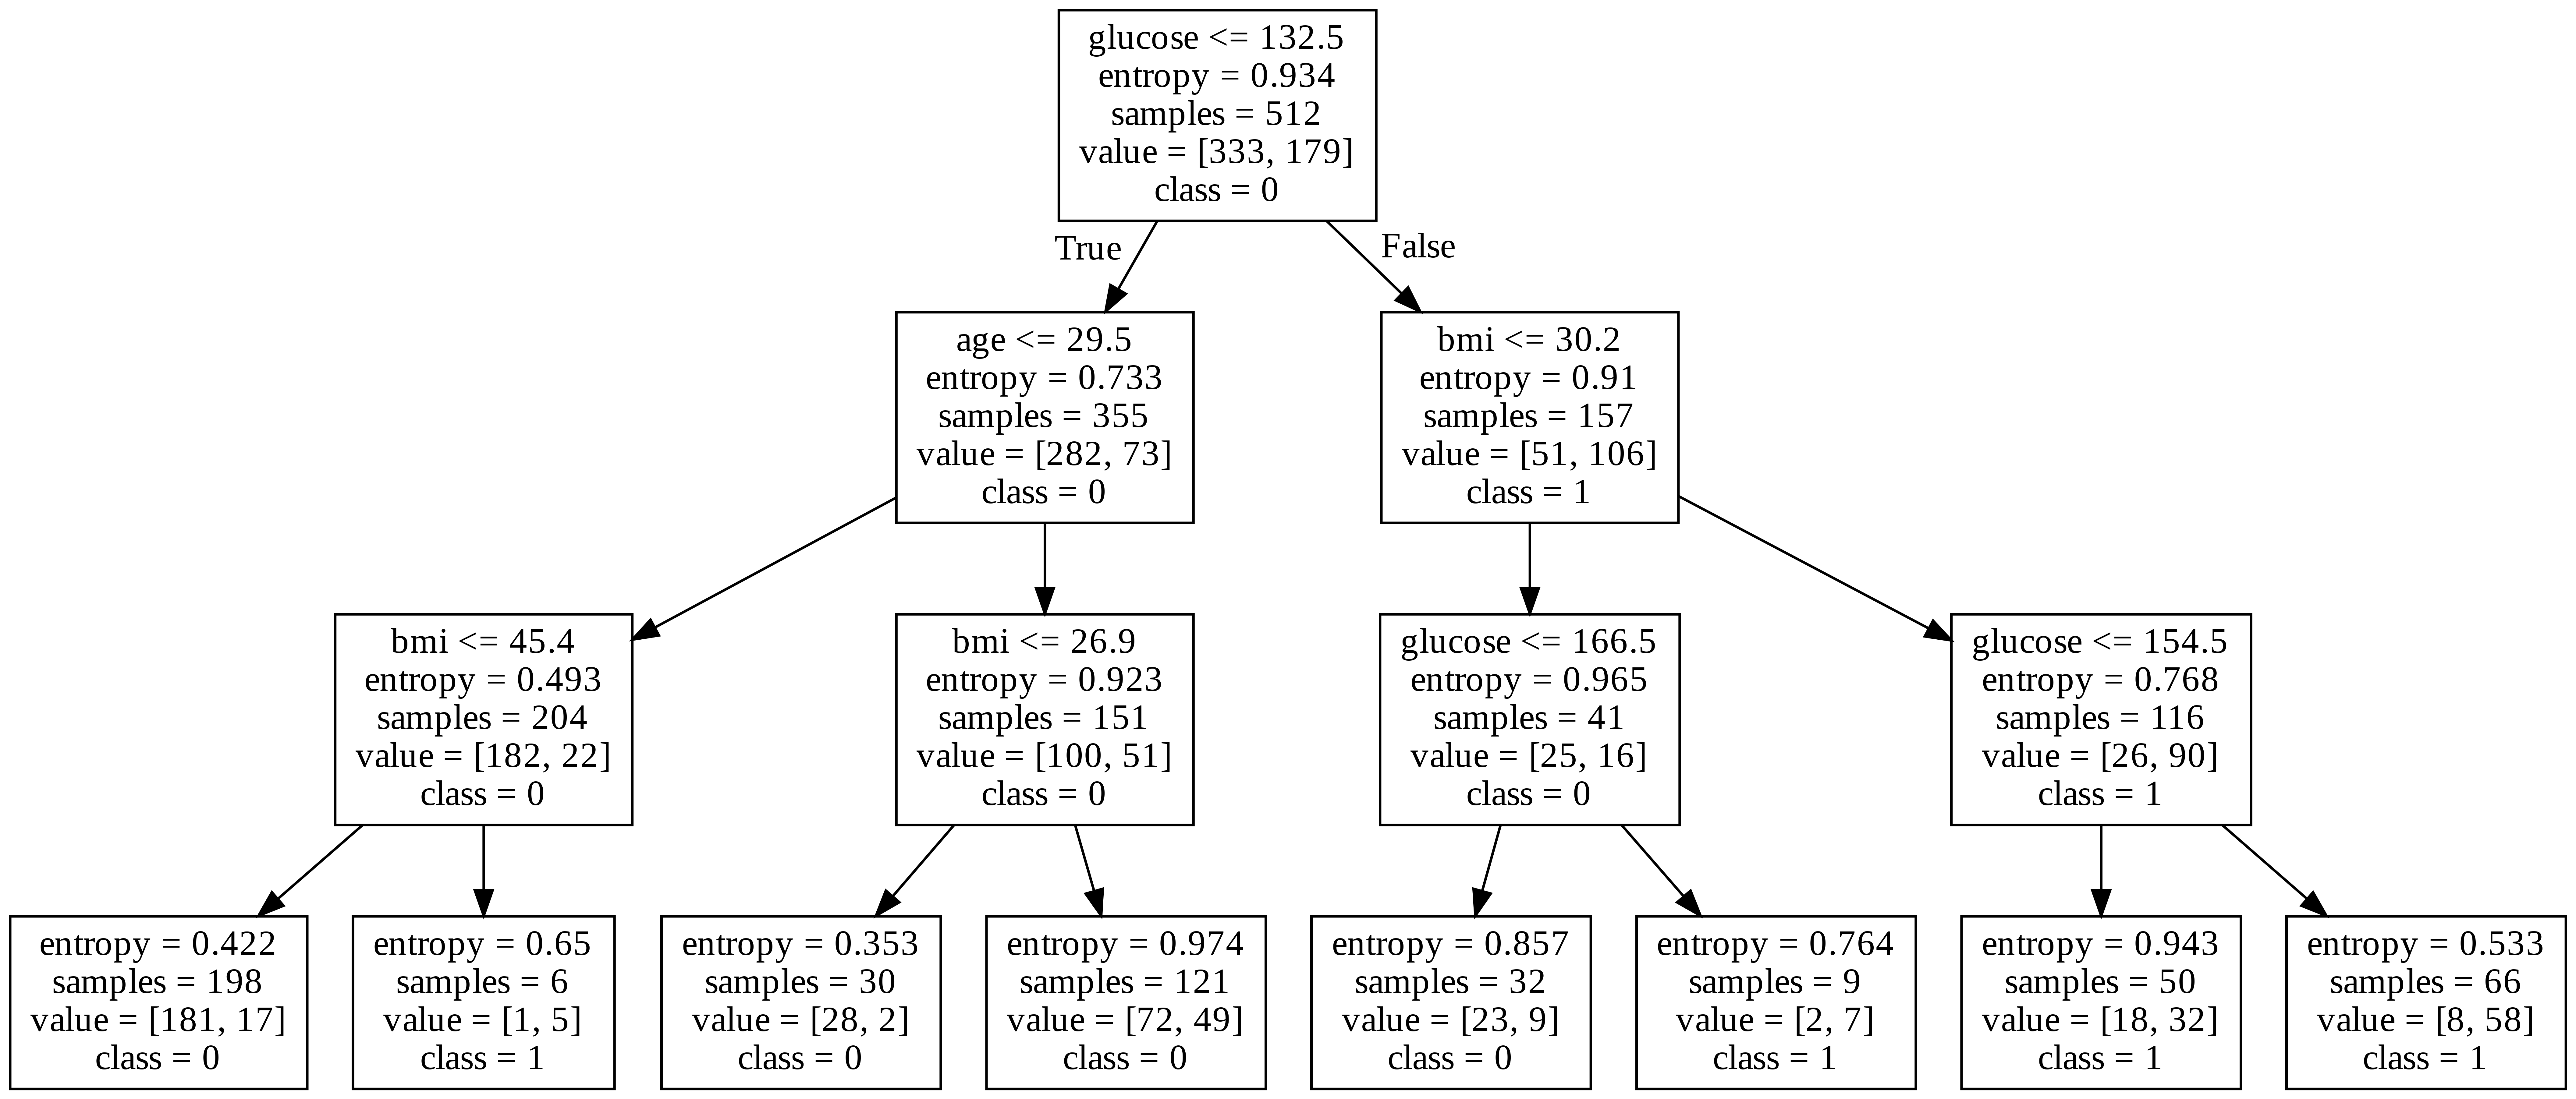

In [36]:
#DT visualizatin method 2
# need to install Graphviz first https://graphviz.gitlab.io/_pages/Download/Download_windows.html
from sklearn.tree import export_graphviz
import os

os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

export_graphviz(dt, out_file='tree.dot', feature_names=X.columns,class_names=['0','1'])
# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')


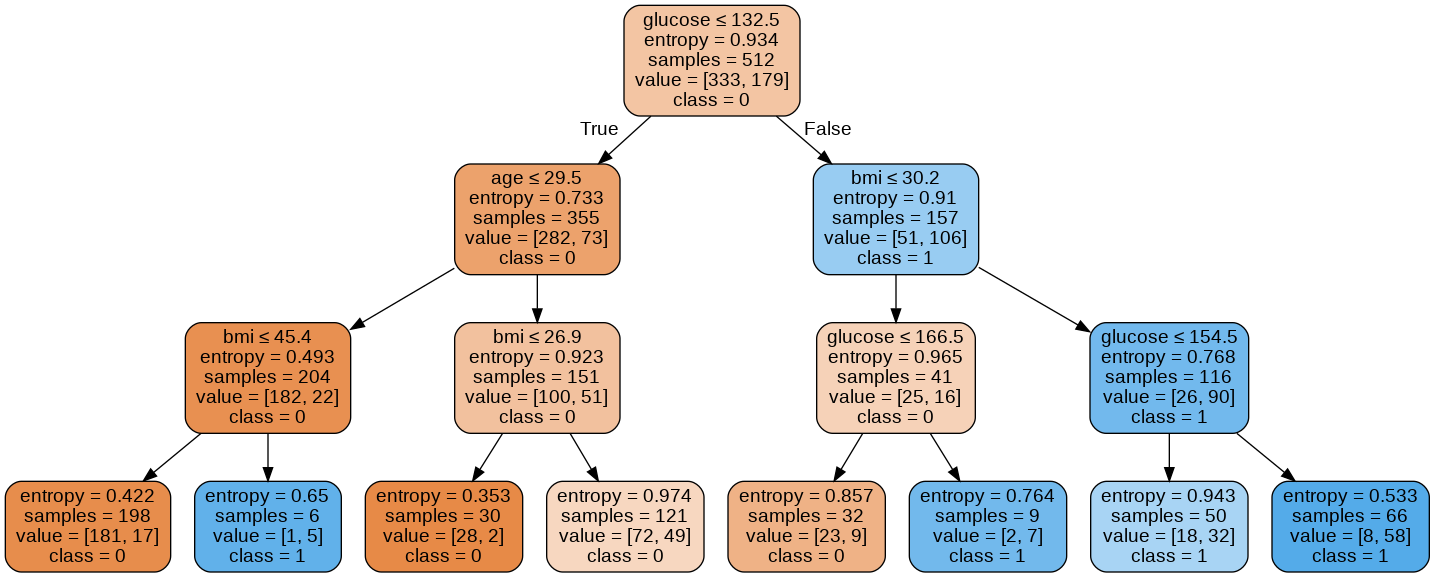

In [37]:
#DT visualizatin method 3
#!conda install -y pydotplus
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X.columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes.png')
Image(graph.create_png())

In [38]:
#Plot ROC chart for DT.Write your code below.

In [39]:
y_scores = dt.predict_proba(X_train)
y_scores = y_scores[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_scores)

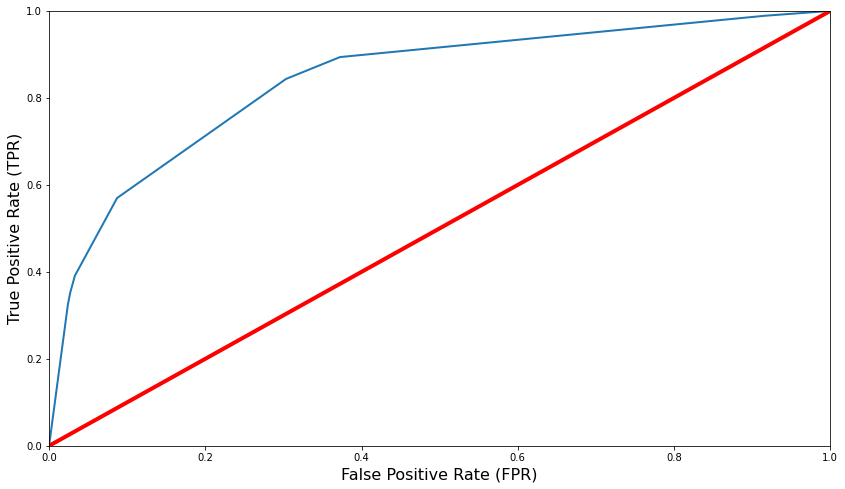

In [40]:
plt.figure(figsize=(14, 8))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

In [41]:
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

# NN

In [42]:

scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)  

In [43]:
from sklearn.neural_network import MLPClassifier  
mlp = MLPClassifier(hidden_layer_sizes=(10,10), max_iter=1000,verbose=2)  
mlp.fit(X_train, y_train)  

Iteration 1, loss = 0.78983154
Iteration 2, loss = 0.77753859
Iteration 3, loss = 0.76589318
Iteration 4, loss = 0.75478584
Iteration 5, loss = 0.74418296
Iteration 6, loss = 0.73462823
Iteration 7, loss = 0.72513383
Iteration 8, loss = 0.71697888
Iteration 9, loss = 0.70896858
Iteration 10, loss = 0.70171394
Iteration 11, loss = 0.69505279
Iteration 12, loss = 0.68827248
Iteration 13, loss = 0.68232074
Iteration 14, loss = 0.67655534
Iteration 15, loss = 0.67101319
Iteration 16, loss = 0.66620284
Iteration 17, loss = 0.66108959
Iteration 18, loss = 0.65633052
Iteration 19, loss = 0.65183203
Iteration 20, loss = 0.64742853
Iteration 21, loss = 0.64323831
Iteration 22, loss = 0.63920615
Iteration 23, loss = 0.63503514
Iteration 24, loss = 0.63115999
Iteration 25, loss = 0.62722005
Iteration 26, loss = 0.62357260
Iteration 27, loss = 0.62004378
Iteration 28, loss = 0.61626882
Iteration 29, loss = 0.61260283
Iteration 30, loss = 0.60915669
Iteration 31, loss = 0.60563042
Iteration 32, los

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 10), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=2, warm_start=False)

In [44]:
predictions = mlp.predict(X_test)  


print("Accuracy", metrics.accuracy_score(y_test, predictions))
print(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions))  

Accuracy 0.7109375
[[139  28]
 [ 46  43]]
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       167
           1       0.61      0.48      0.54        89

    accuracy                           0.71       256
   macro avg       0.68      0.66      0.66       256
weighted avg       0.70      0.71      0.70       256



In [45]:
print("Accuracy on training set: {:.3f}".format(mlp.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp.score(X_test, y_test)))

Accuracy on training set: 0.846
Accuracy on test set: 0.711


In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib 
import pandas as pd
import numpy as np

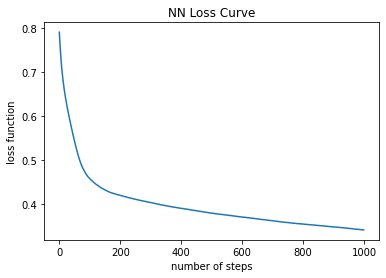

In [47]:
plt.plot(mlp.loss_curve_)
plt.title("NN Loss Curve")
plt.xlabel("number of steps")
plt.ylabel("loss function")
plt.show()

In [48]:
(mlp.intercepts_[0]).shape

(10,)

In [49]:
(mlp.coefs_[0]).shape

(8, 10)

In [50]:
mlp.intercepts_[0]

array([-0.72705956,  0.70654442,  0.5197185 ,  0.52511168, -0.79769878,
        0.28865111, -0.73865423,  0.71558738, -0.12071287, -0.97101163])

In [51]:
mlp.coefs_[0]

array([[-0.27070252,  0.23881282, -0.3489705 ,  0.16106581,  0.86596551,
        -0.43114964,  0.30781102,  0.326227  ,  0.34200936, -0.14287377],
       [ 0.37434252,  0.4603261 ,  0.17701113, -0.46893205, -0.28553553,
        -0.67026511,  0.78989561, -0.12851084, -1.51716078,  0.23374955],
       [-0.50209506, -0.40566816, -0.30683202,  0.9699912 , -0.21572171,
         0.37846626,  0.4482323 , -1.58885906, -0.23096215, -0.27287742],
       [ 0.22247684,  0.12139479, -0.06278126,  0.81010572,  0.61629141,
        -0.14791098, -0.40904457,  0.08873513,  0.56882501, -0.38169115],
       [ 0.23312637,  0.04544877,  0.08229836,  0.03876183, -0.17501612,
         0.11744636,  0.47336079,  0.25207906,  0.80807542,  0.07995876],
       [ 0.51068042,  0.41353698, -0.31493954,  0.06243569, -0.10498684,
        -0.38665389,  0.70092862, -0.25559081,  0.40669988,  0.48955273],
       [ 0.14316071,  0.71113147,  0.34517243,  0.44530713,  0.3509958 ,
         0.25610056, -0.59862734, -0.22585153

# SVM

In [52]:
from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 1
C1, C2 = 1, 10
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

scaler = StandardScaler()  
scaler.fit(X_train)
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

svm_clfs = []
for gamma, C in hyperparams:
    svm_clf=SVC(kernel="rbf",gamma=gamma, C=C) 
    svm_clf.fit(X_train,y_train)
    svm_clfs.append(svm_clf)

from sklearn.metrics import classification_report, confusion_matrix  
for i, svm_clf in enumerate(svm_clfs):
    predictions = svm_clf.predict(X_test)  
    gamma, C = hyperparams[i]
    print("r=", gamma, "C=", C)
    print("Accuracy=", metrics.accuracy_score(y_test, predictions))
    print(confusion_matrix(y_test,predictions))  
    print(classification_report(y_test,predictions))  


r= 0.1 C= 1
Accuracy= 0.75390625
[[143  24]
 [ 39  50]]
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       167
           1       0.68      0.56      0.61        89

    accuracy                           0.75       256
   macro avg       0.73      0.71      0.72       256
weighted avg       0.75      0.75      0.75       256

r= 0.1 C= 10
Accuracy= 0.7109375
[[134  33]
 [ 41  48]]
              precision    recall  f1-score   support

           0       0.77      0.80      0.78       167
           1       0.59      0.54      0.56        89

    accuracy                           0.71       256
   macro avg       0.68      0.67      0.67       256
weighted avg       0.71      0.71      0.71       256

r= 1 C= 1
Accuracy= 0.70703125
[[150  17]
 [ 58  31]]
              precision    recall  f1-score   support

           0       0.72      0.90      0.80       167
           1       0.65      0.35      0.45        89

    accuracy    

In [53]:
#Apply svm model
svm_model = svm.SVC(probability=True)
svm_model.fit(X, y)
svm_model_score = round(svm_model.score(X, y) * 100, 2)
print(str(svm_model_score) + '%')

76.82%


# deployment 

In [54]:
import pickle
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(mlp, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, y_test)
#print(result)

pred = loaded_model.predict(X_test)
print(pred)


[0 0 0 0 1 1 1 1 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1
 0 1 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 1
 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0
 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1
 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1 1 0 0 1
 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0]


In [55]:
#score the model on a scoring data set

#diabetes_score_data = pd.read_csv('.....csv')

#sc_X = StandardScaler()
#X =  sc_X.fit_transform(diabetes_score_data)

#pred = loaded_model.predict(X)
#print(pred)



In [56]:
np.savetxt("/content/f.csv", pred, fmt="%d", delimiter=",")

# Additional code for your reference: 
https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html